# Bank Marketing 참여 여부 예측

##### 모듈 import

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay

## 1. Load Dataset

In [16]:
# 데이터 불러오기
df_trn = pd.read_csv('data/train.csv')
df_tst = pd.read_csv('data/test.csv')

In [6]:
df_trn.head()

,ID,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,label
0,train00001,34,blue-collar,married,primary,no,358,yes,no,unknown,23,may,100,4,-1,0,unknown,0
1,train00002,33,blue-collar,married,secondary,no,-53,yes,no,unknown,20,may,172,1,-1,0,unknown,0
2,train00003,32,management,single,tertiary,no,207,yes,no,cellular,2,feb,56,1,-1,0,unknown,0
3,train00004,37,blue-collar,divorced,secondary,no,638,yes,no,cellular,8,may,326,1,326,2,success,0
4,train00005,33,housemaid,married,secondary,no,826,yes,no,cellular,11,may,256,1,-1,0,unknown,0


In [7]:
df_tst.head()

,ID,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,label
0,test00001,54,management,divorced,tertiary,no,6410,no,no,cellular,20,nov,101,2,-1,0,unknown,NaN
1,test00002,56,unemployed,divorced,primary,no,282,no,no,cellular,28,jan,156,2,-1,0,unknown,NaN
2,test00003,34,management,married,secondary,no,355,no,no,cellular,21,aug,314,3,-1,0,unknown,NaN
3,test00004,55,management,married,tertiary,no,568,no,no,cellular,12,aug,940,10,-1,0,unknown,NaN
4,test00005,38,technician,married,secondary,no,6728,no,no,cellular,21,aug,252,4,-1,0,unknown,NaN


- ID (변수 사용 금지)
- age: 나이 (수치형)
- job: 직업 (범주형)
- marital: 결혼상태 (범주형) married, devorced, single 
- education: 학력 (범주형) unkown, sceondary, primary, tertiary
- default: 신용 채무 불이행 상태 (범주형)  yes, no
- balance: 연평균 잔액 (수치형)
- housing: 주택대출 여부 (범주형) yes, no
- loan: 개인대출 여부 (범주형) yes, no
- contact: 최근 연락을 한 방법 (범주형) unkown, telephone, celluar
- day: 최근 연락을 한 날 (수치형)
- month: 최근 연락을 한 달 (수치형)
- duration: 최근 연락시 통화 시간 (수치형)
- campaign: 이번 캠페인 관련 취한 연락 횟수 (수치형)
- pdays: 지난 캠페인 관련하여 마지막 연락으로부터 경과한 일수 (수치형) -1은 연락한 적 없음
- previous: 이전 캠페인 이전에 해당 고객에세 취한 연락 횟수 (수치형)
- poutcome: 이전 캠페인 참여 여부 (범주형) unkown, other, falure, success
- label: 예측 변수

## 2. EDA

#### (1) 데이터 구조 및 기본 정보 확인

In [11]:
df_trn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31647 entries, 0 to 31646
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         31647 non-null  object
 1   age        31647 non-null  int64 
 2   job        31647 non-null  object
 3   marital    31647 non-null  object
 4   education  31647 non-null  object
 5   default    31647 non-null  object
 6   balance    31647 non-null  int64 
 7   housing    31647 non-null  object
 8   loan       31647 non-null  object
 9   contact    31647 non-null  object
 10  day        31647 non-null  int64 
 11  month      31647 non-null  object
 12  duration   31647 non-null  int64 
 13  campaign   31647 non-null  int64 
 14  pdays      31647 non-null  int64 
 15  previous   31647 non-null  int64 
 16  poutcome   31647 non-null  object
 17  label      31647 non-null  int64 
dtypes: int64(8), object(10)
memory usage: 4.3+ MB


In [12]:
df_tst.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13564 entries, 0 to 13563
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         13564 non-null  object 
 1   age        13564 non-null  int64  
 2   job        13564 non-null  object 
 3   marital    13564 non-null  object 
 4   education  13564 non-null  object 
 5   default    13564 non-null  object 
 6   balance    13564 non-null  int64  
 7   housing    13564 non-null  object 
 8   loan       13564 non-null  object 
 9   contact    13564 non-null  object 
 10  day        13564 non-null  int64  
 11  month      13564 non-null  object 
 12  duration   13564 non-null  int64  
 13  campaign   13564 non-null  int64  
 14  pdays      13564 non-null  int64  
 15  previous   13564 non-null  int64  
 16  poutcome   13564 non-null  object 
 17  label      0 non-null      float64
dtypes: float64(1), int64(7), object(10)
memory usage: 1.9+ MB


In [13]:
# 수치형 데이터 통계 정보 확인
df_trn.describe()

,age,balance,day,duration,campaign,pdays,previous,label
count,31647.000000,31647.000000,31647.000000,31647.000000,31647.000000,31647.000000,31647.000000,31647.000000
mean,40.916833,1370.050084,15.818277,258.088824,2.752615,40.023604,0.575062,0.116978
std,10.621773,3122.054996,8.315467,255.737568,3.080952,100.154518,2.433034,0.321399
min,18.000000,-4057.000000,1.000000,0.000000,1.000000,-1.000000,0.000000,0.000000
25%,33.000000,73.000000,8.000000,103.000000,1.000000,-1.000000,0.000000,0.000000
50%,39.000000,451.000000,16.000000,180.000000,2.000000,-1.000000,0.000000,0.000000
75%,48.000000,1418.500000,21.000000,320.000000,3.000000,-1.000000,0.000000,0.000000
max,95.000000,102127.000000,31.000000,3881.000000,63.000000,854.000000,275.000000,1.000000


In [14]:
df_tst.describe()

,age,balance,day,duration,campaign,pdays,previous,label
count,13564.000000,13564.000000,13564.000000,13564.000000,13564.000000,13564.00000,13564.000000,0.0
mean,40.981421,1344.124668,15.778753,258.336331,2.790032,40.60432,0.592598,NaN
std,10.611987,2856.346280,8.339047,261.666551,3.137443,100.07110,1.968204,NaN
min,18.000000,-8019.000000,1.000000,1.000000,1.000000,-1.00000,0.000000,NaN
25%,33.000000,70.000000,8.000000,102.000000,1.000000,-1.00000,0.000000,NaN
50%,39.000000,442.000000,16.000000,180.000000,2.000000,-1.00000,0.000000,NaN
75%,48.000000,1442.000000,21.000000,316.000000,3.000000,-1.00000,0.000000,NaN
max,95.000000,71188.000000,31.000000,4918.000000,58.000000,871.00000,40.000000,NaN


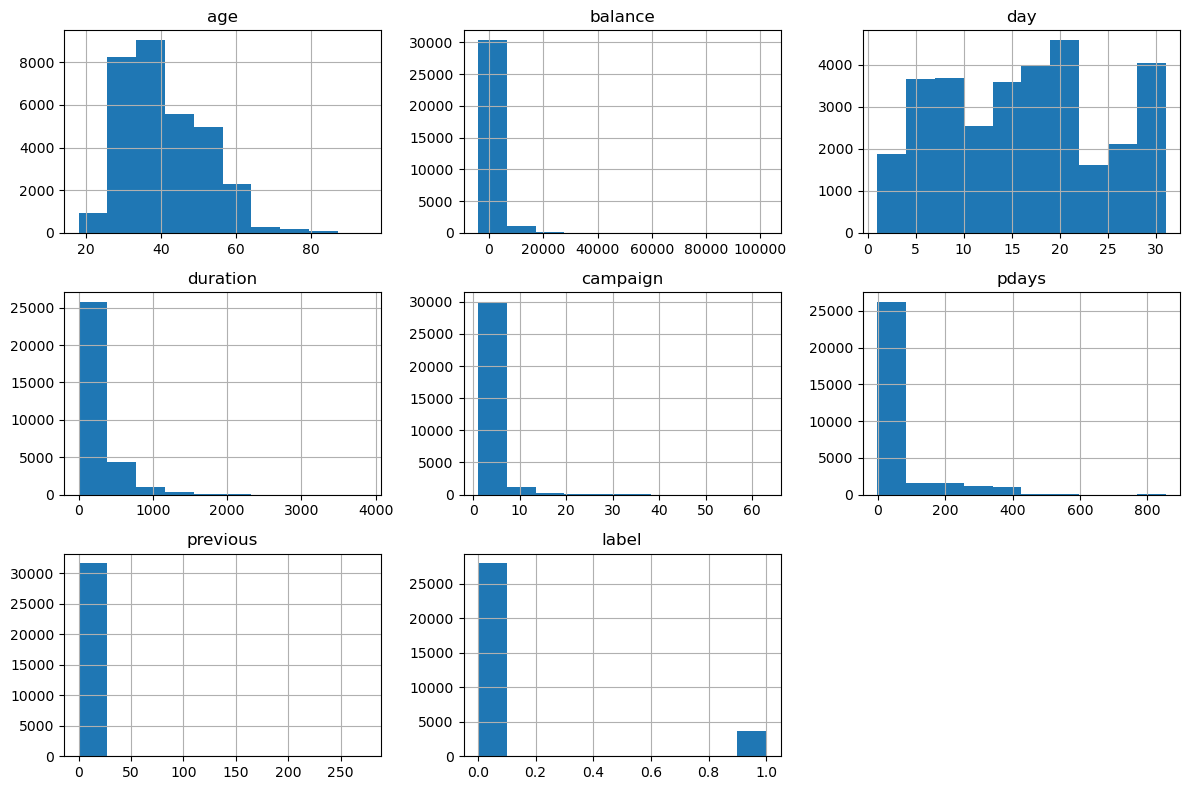

In [15]:
df_trn.hist(figsize=(12,8))
plt.tight_layout()

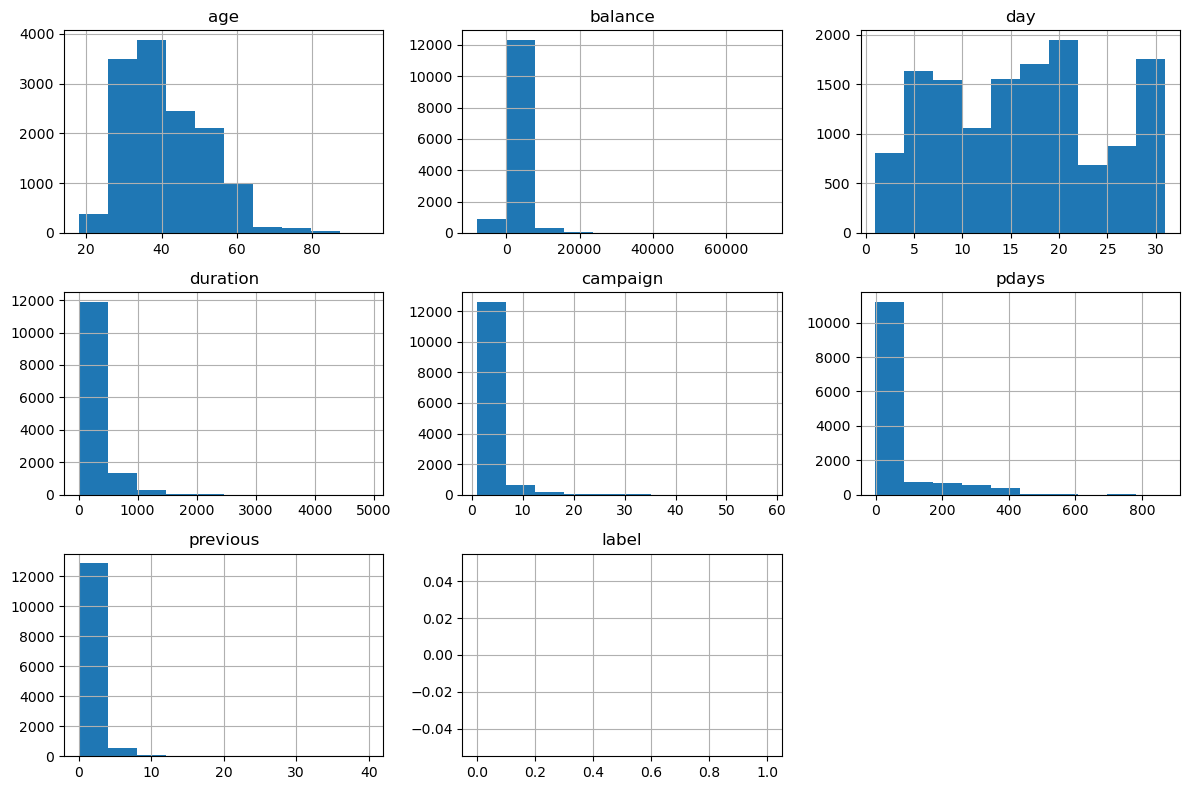

In [16]:
df_tst.hist(figsize=(12,8))
plt.tight_layout()

In [17]:
# 중복 데이터 확인
df_trn.duplicated().sum() 

0

In [18]:
df_tst.duplicated().sum() 

0

#### (2) Label (타겟 변수)의 분포 확인

<Axes: xlabel='label'>

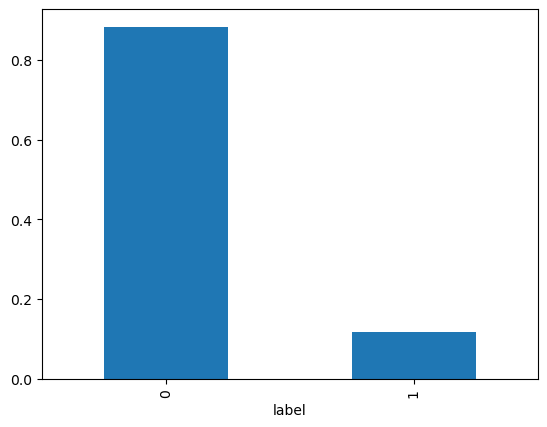

In [20]:
df_trn['label'].value_counts(normalize=True).plot(kind='bar')

#### (3) 수치형 변수 분석

In [22]:
# 수치형 변수 정의
num_cols = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

In [23]:
# 분포와 이상치 확인 함수
def num_plot(df, num_cols):
    for col in num_cols:
        plt.figure(figsize=(14, 6))

        # 분포 확인
        plt.subplot(1, 2, 1)
        sns.histplot(df[col], kde=True, bins=30, color='blue', edgecolor='black')
        plt.title(f'{col} Distribution', fontsize=14)
        plt.xlabel(col)
        plt.ylabel('Frequency')

        # 이상치 확인 (Boxplot)
        plt.subplot(1, 2, 2)
        sns.boxplot(y=df[col], color='orange')
        plt.title(f'{col} Outliers', fontsize=14)
        plt.ylabel(col)

        plt.tight_layout()
        plt.show()

        # IQR을 이용한 이상치 탐지
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)] # 이상치 개수

        print(f'▶ {col}')
        print(f'  - IQR: {IQR}')
        print(f'  - Lower Bound: {lower_bound}, Upper Bound: {upper_bound}')
        print(f'  - Number of Outliers: {outliers.shape[0]}\n')

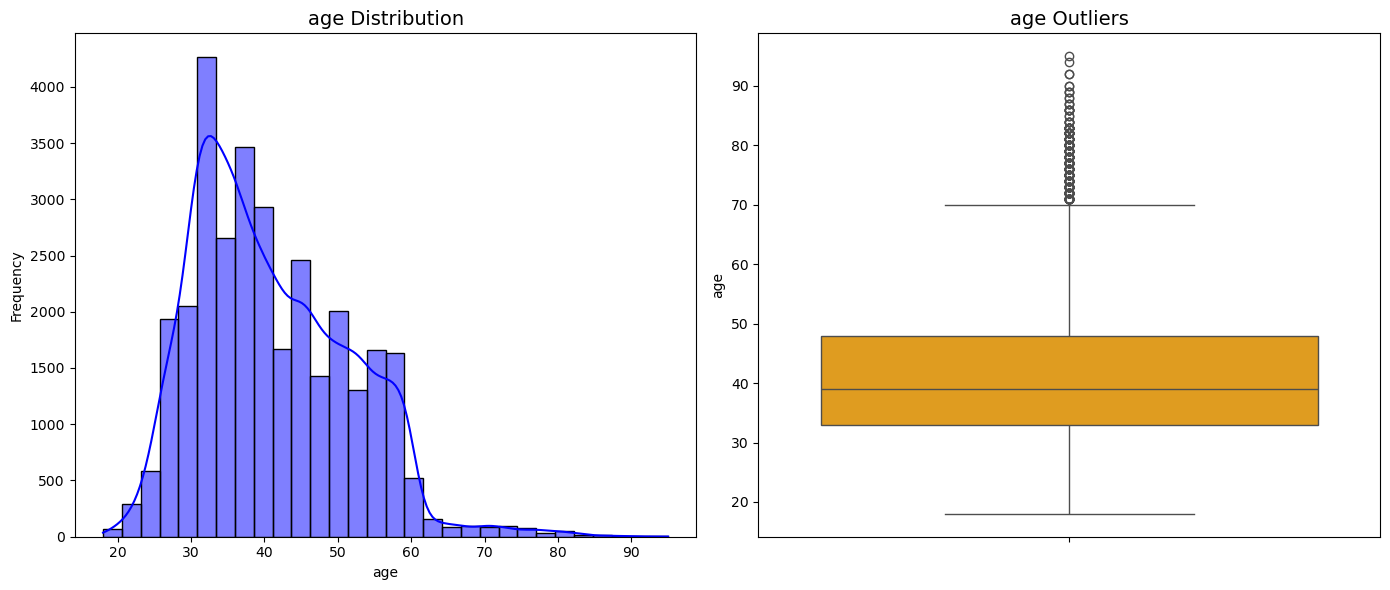

▶ age
  - IQR: 15.0
  - Lower Bound: 10.5, Upper Bound: 70.5
  - Number of Outliers: 337



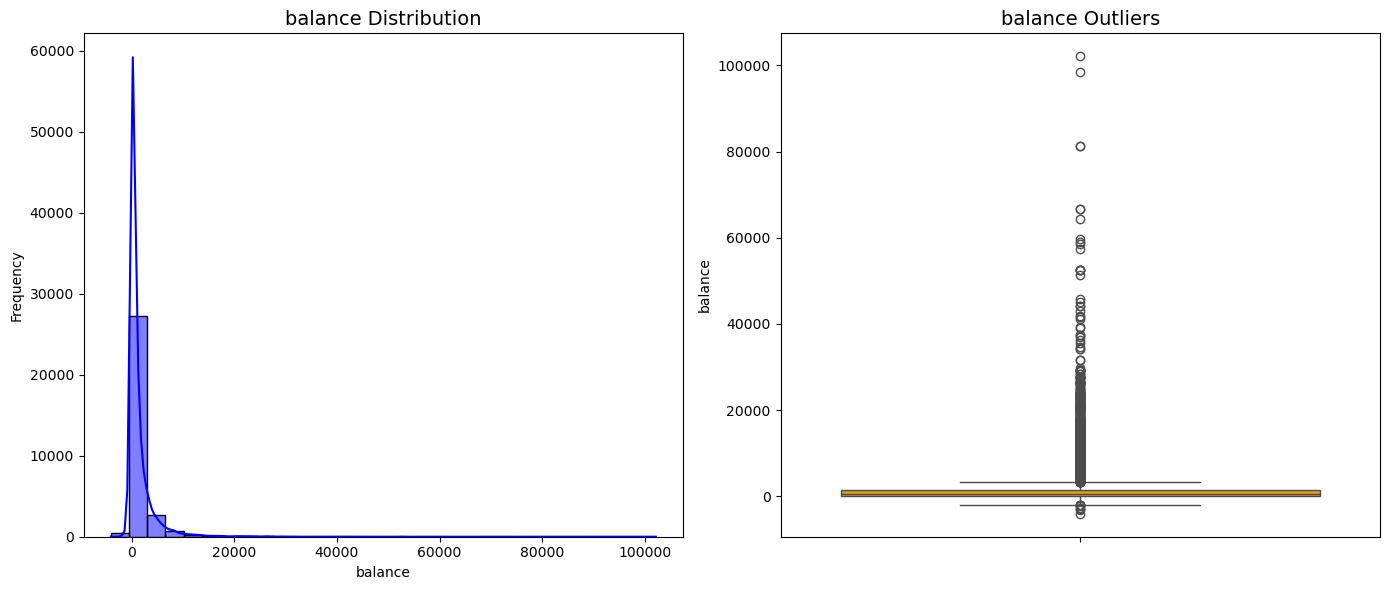

▶ balance
  - IQR: 1345.5
  - Lower Bound: -1945.25, Upper Bound: 3436.75
  - Number of Outliers: 3327



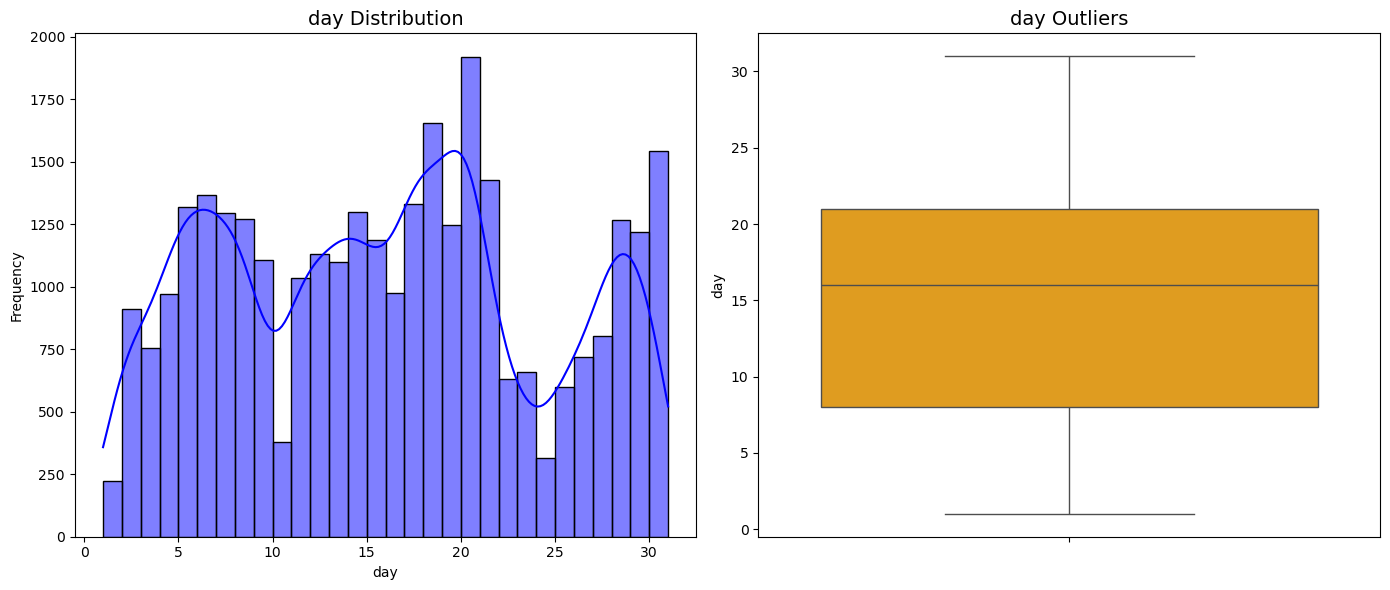

▶ day
  - IQR: 13.0
  - Lower Bound: -11.5, Upper Bound: 40.5
  - Number of Outliers: 0



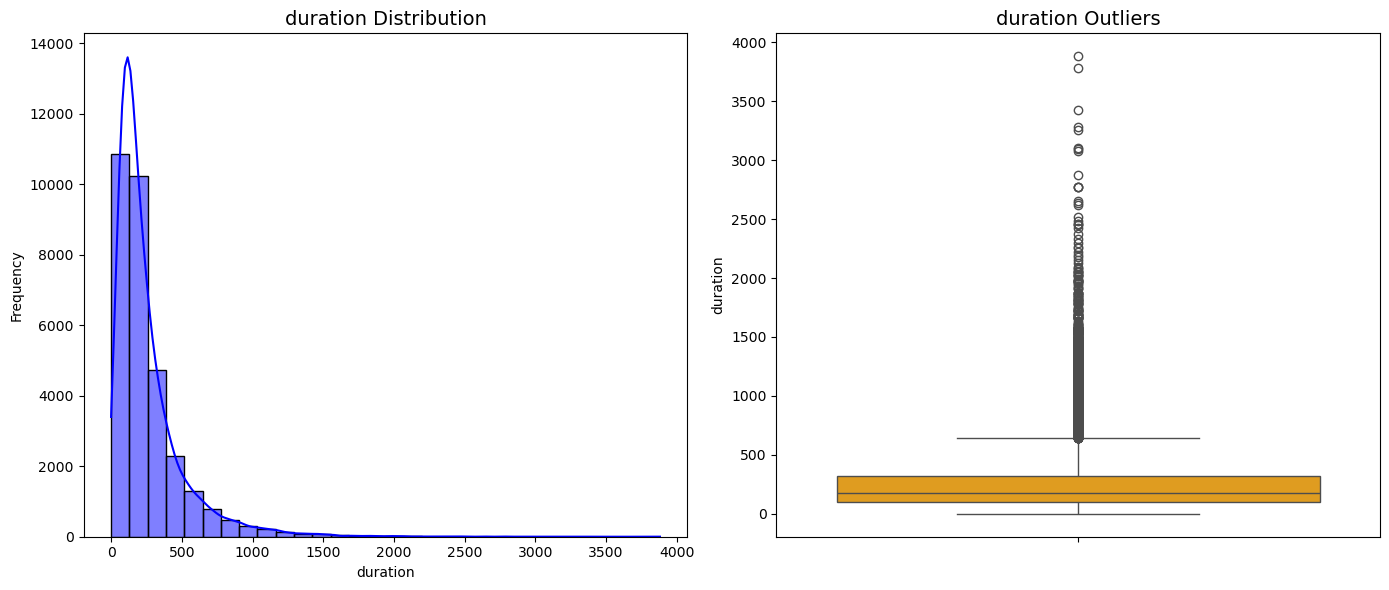

▶ duration
  - IQR: 217.0
  - Lower Bound: -222.5, Upper Bound: 645.5
  - Number of Outliers: 2242



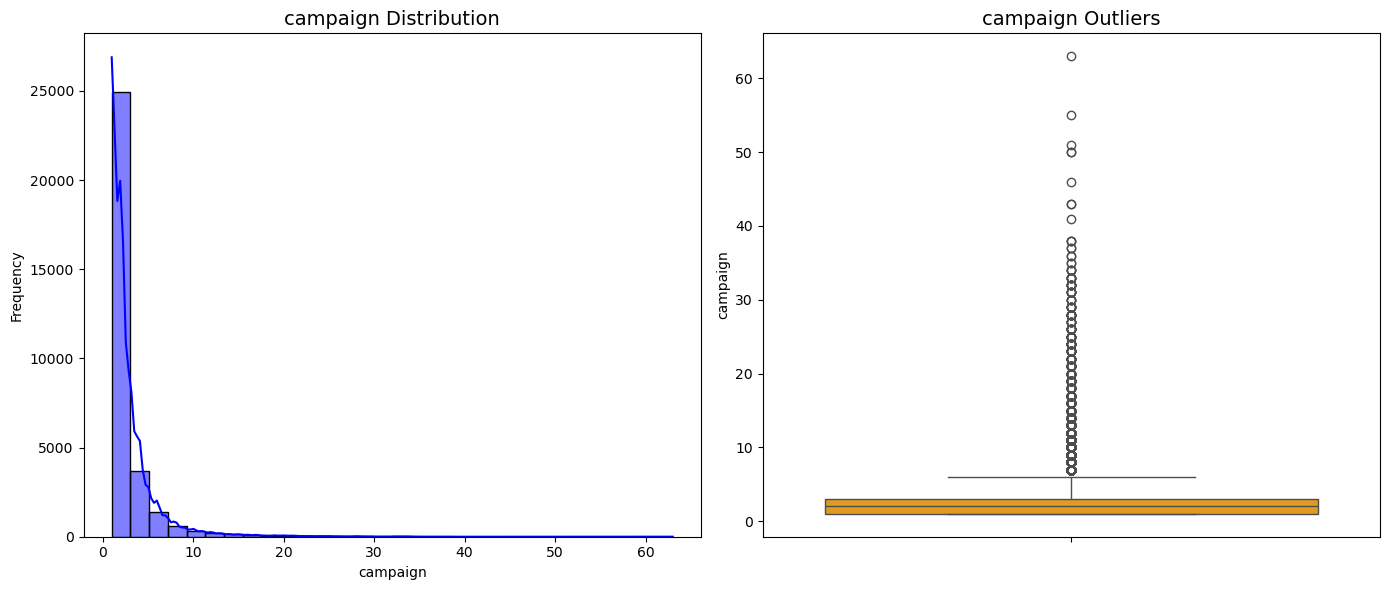

▶ campaign
  - IQR: 2.0
  - Lower Bound: -2.0, Upper Bound: 6.0
  - Number of Outliers: 2134



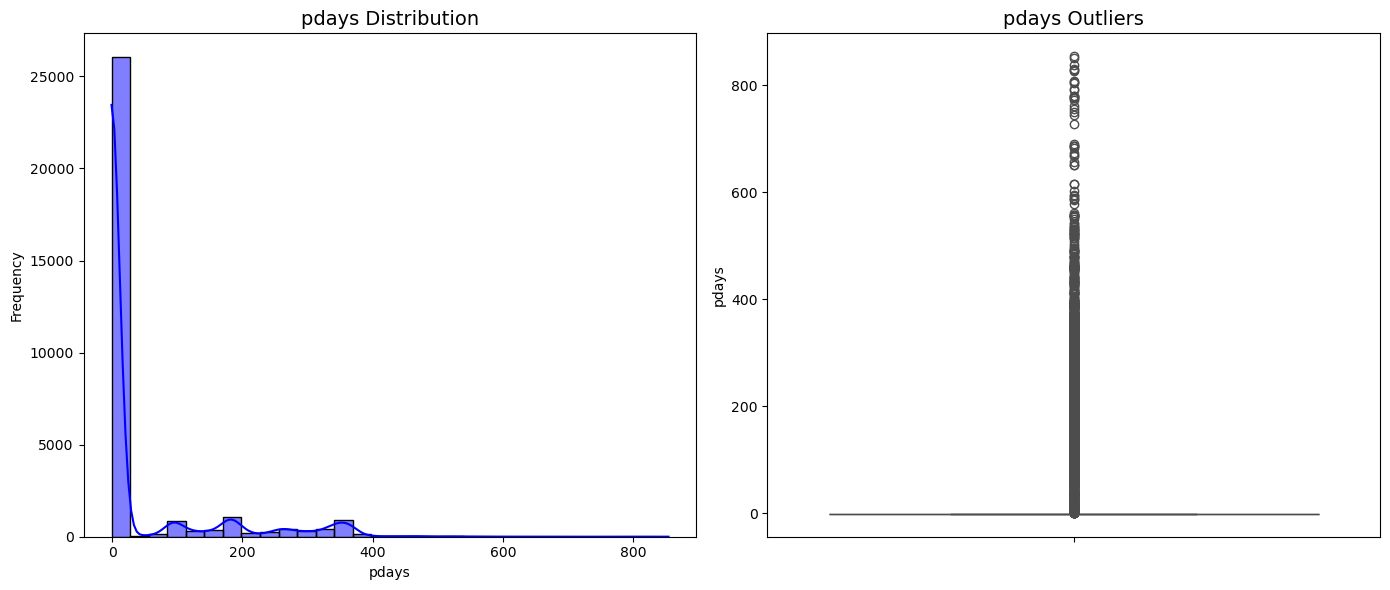

▶ pdays
  - IQR: 0.0
  - Lower Bound: -1.0, Upper Bound: -1.0
  - Number of Outliers: 5733



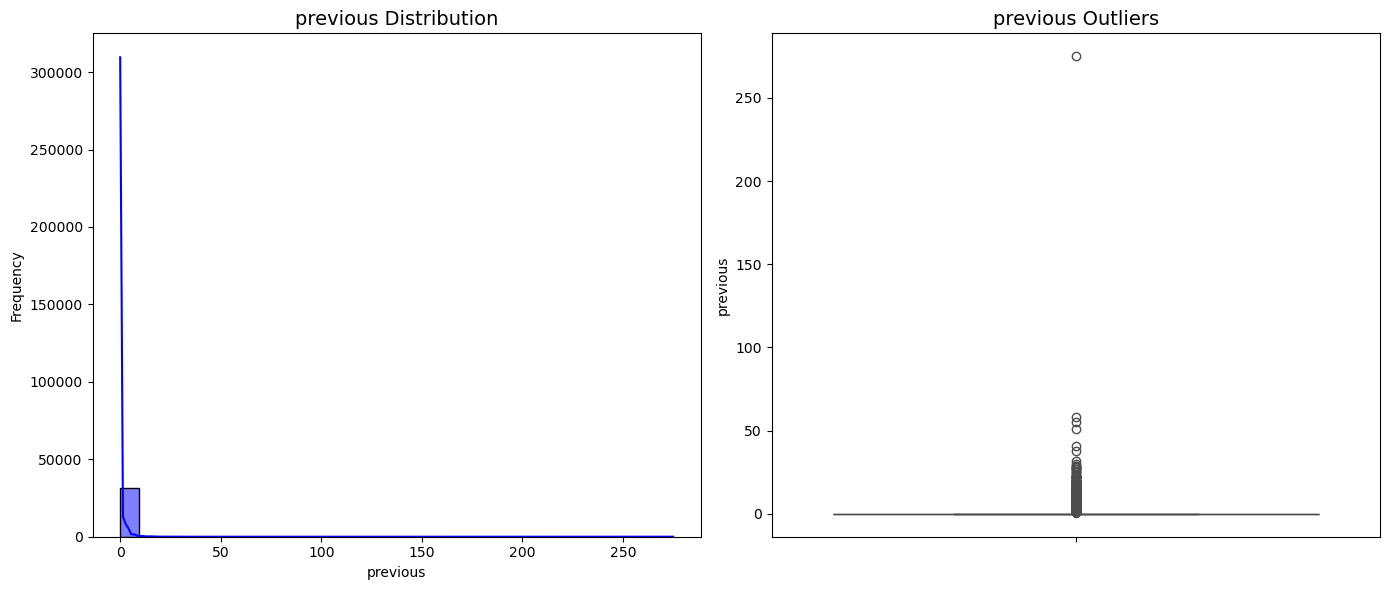

▶ previous
  - IQR: 0.0
  - Lower Bound: 0.0, Upper Bound: 0.0
  - Number of Outliers: 5733



In [24]:
# 함수 호출
num_plot(df_trn, num_cols)

(1) 히스토그램 - 분포 확인
- 정규 분포 여부: 데이터가 정규분포 (좌우 대칭)에 가까운가? -> 그렇지 않다면 로그 변환 등 정규화 고려
- 왜도: 오른쪽 꼬리가 길면 양의 왜도, 왼쪽이면 음의 왜도 -> 왜도가 크면 로그 변환, 루트 변환 시도
- 이상치가 많은 경우: 값의 대부분이 몰려 있음 -> 데이터 분포를 조정하거나 이상치 처리 할 필요 있음

(2) boxplot - 이상치 확인
- 사분위수(IQR) 범위: 박스 내부 데이터로, 박스 양 끝선은 정상 범위의 데이터 / 박스 밖의 점들은 이상치
- 이상치의 빈도와 크기: 이상치가 많다면 이유 분석 / 극단적인 이상치는 클리핑 또는 제거
- 이상가 중요하다면 그대로 유지, 모델에 악영향을 준다면 제거, 상향선/하향선을 설정하거나 로그 변환으로 분포 조

<Axes: >

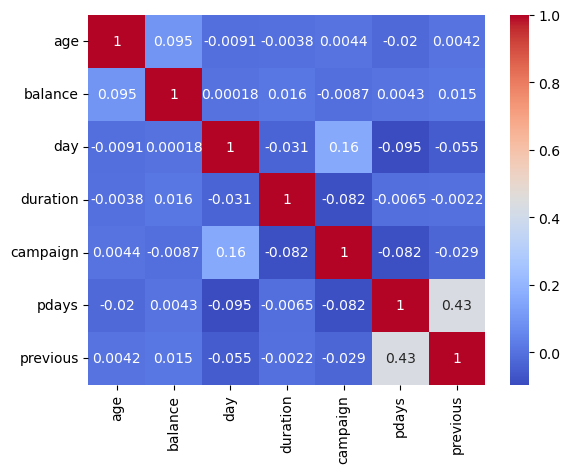

In [26]:
# 상관계수 히트맵
sns.heatmap(df_trn[num_cols].corr(), annot=True, cmap='coolwarm')

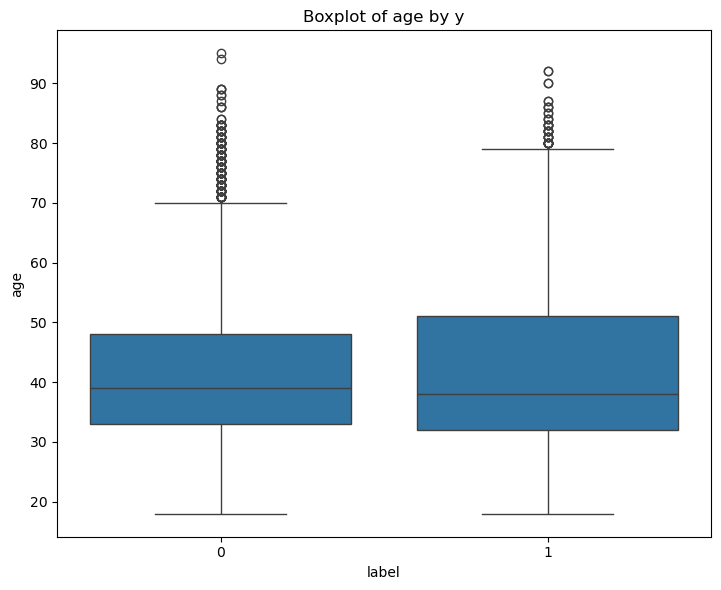

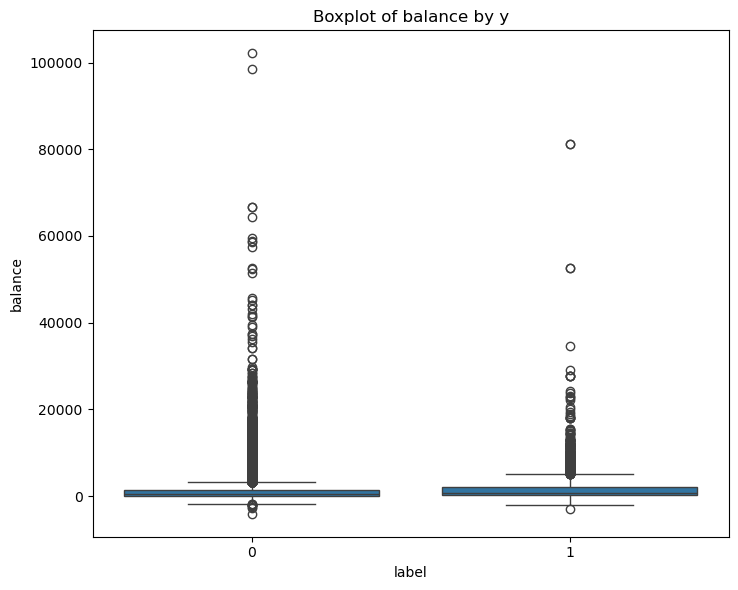

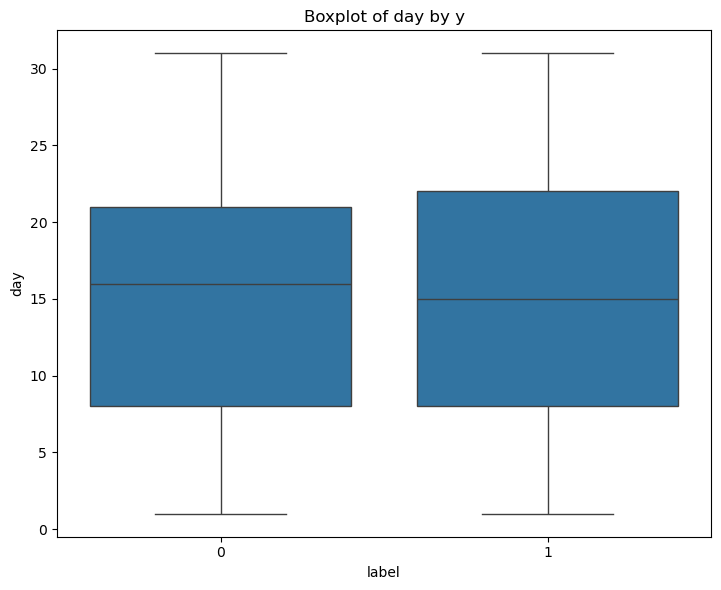

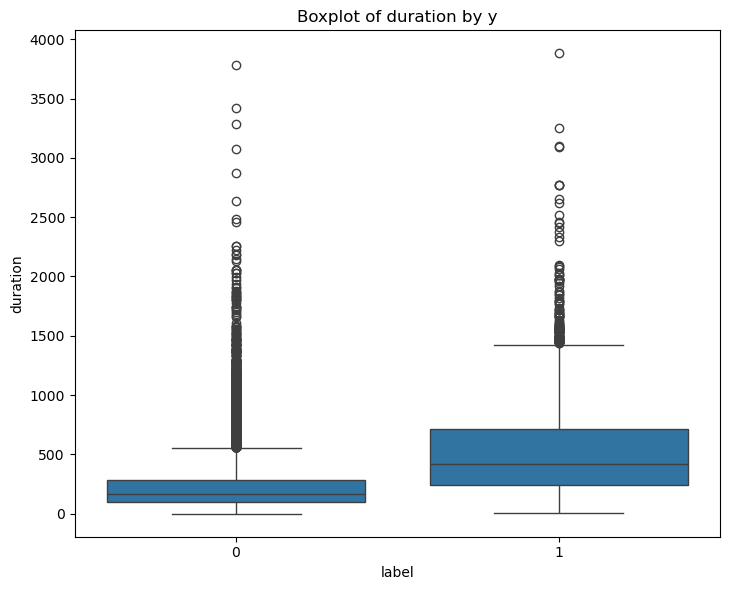

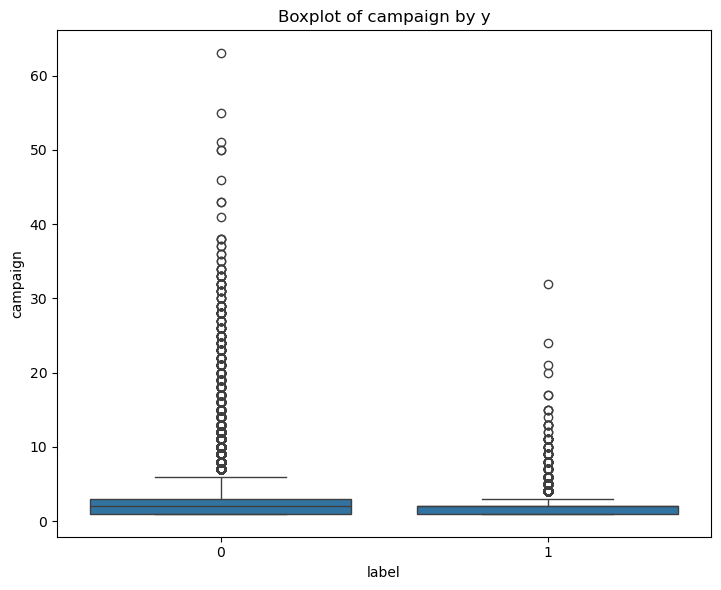

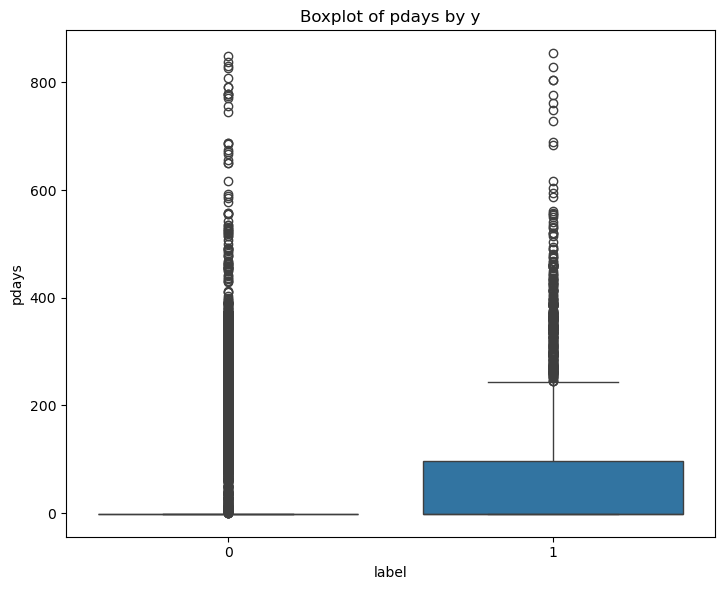

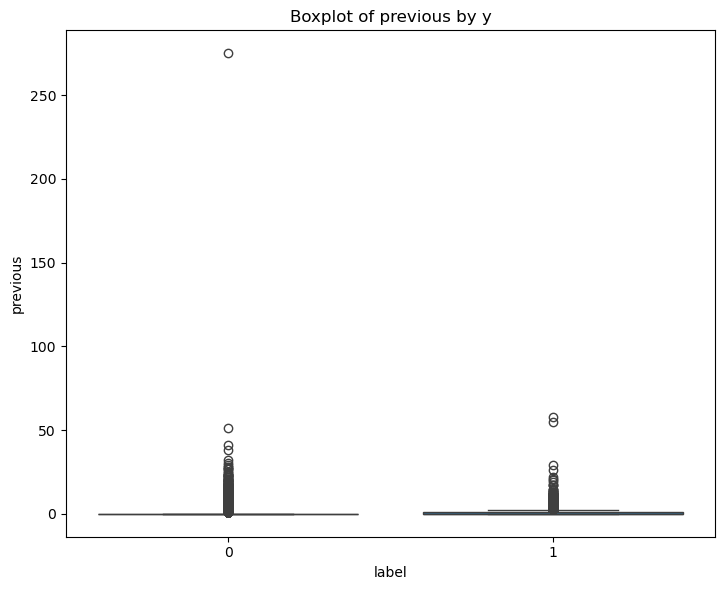

In [27]:
# 가입 여부에 따른 수치형 변수 변화
for col in num_cols:
    plt.figure(figsize=(14, 6))

    # Boxplot
    plt.subplot(1, 2, 1)
    sns.boxplot(x='label', y=col, data=df_trn)
    plt.title(f'Boxplot of {col} by y')
    plt.xlabel('label')
    plt.ylabel(col)

    plt.tight_layout()
    plt.show()

#### (4) 범주형 변수 분석

In [29]:
# 범주형 변수 정의
cat_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

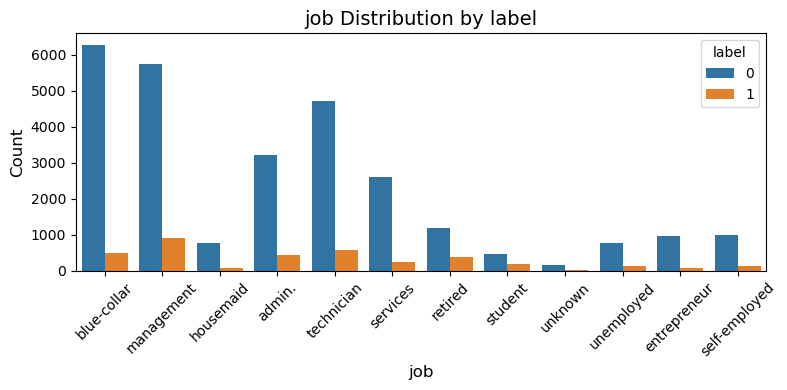

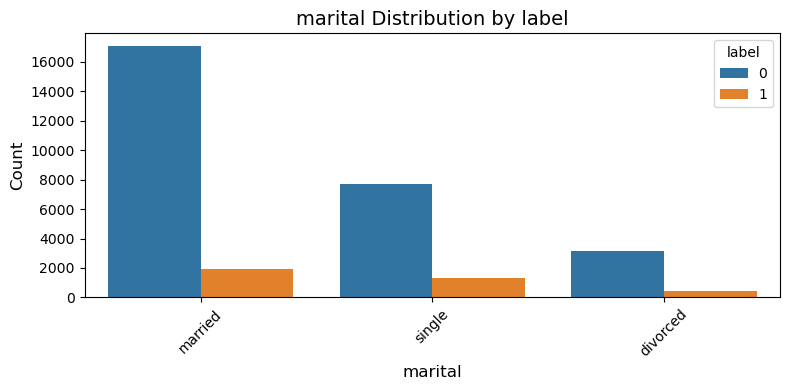

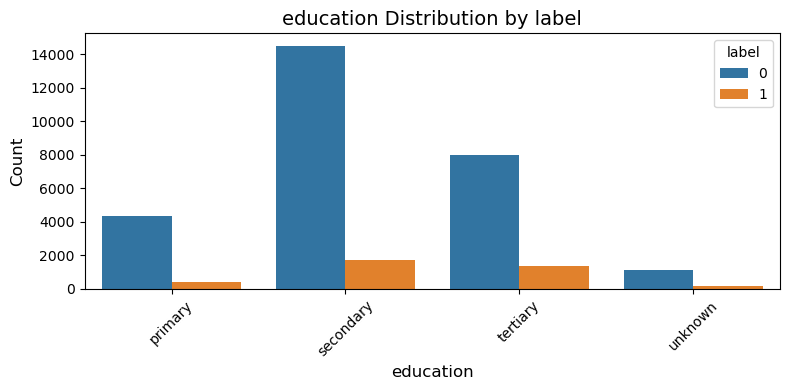

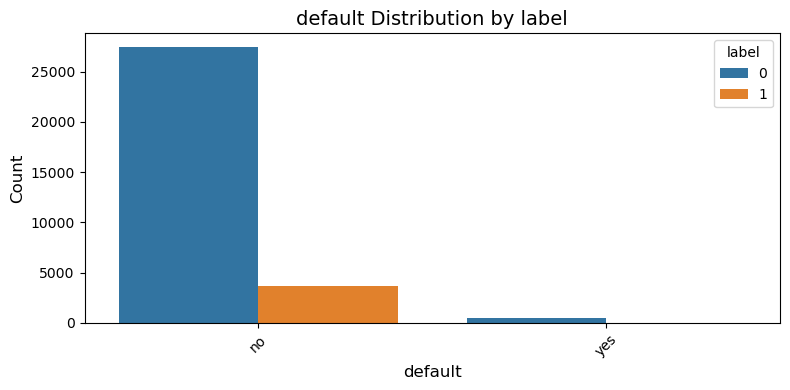

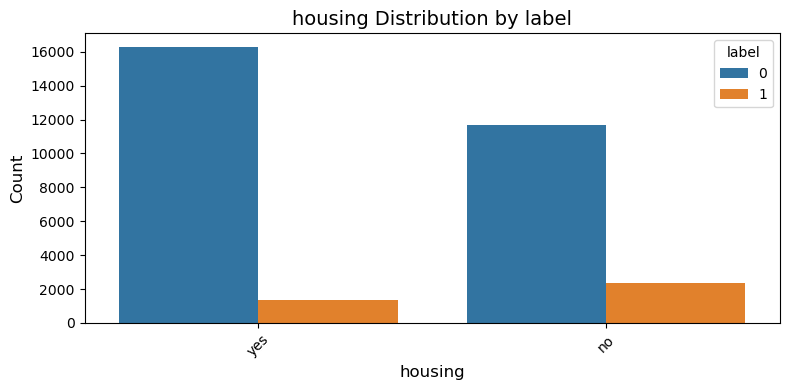

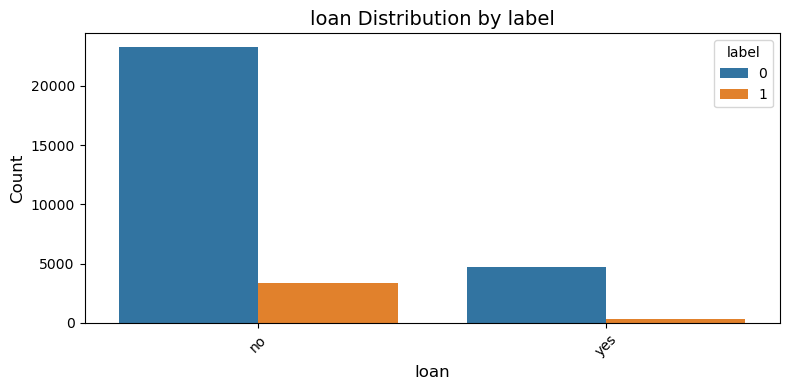

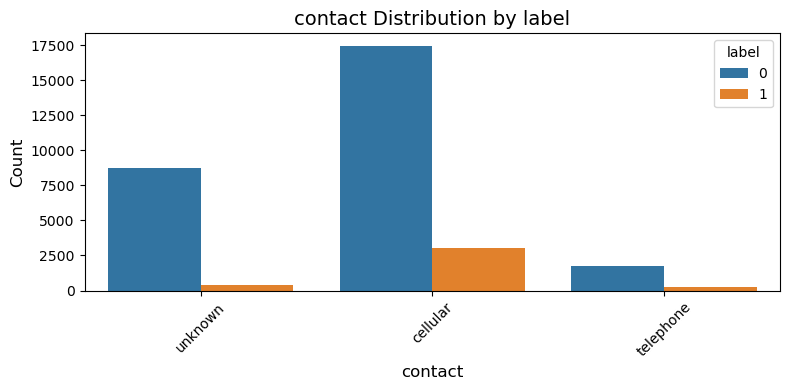

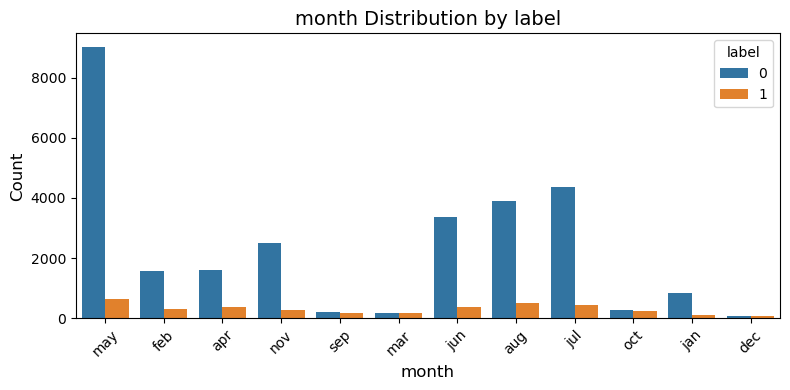

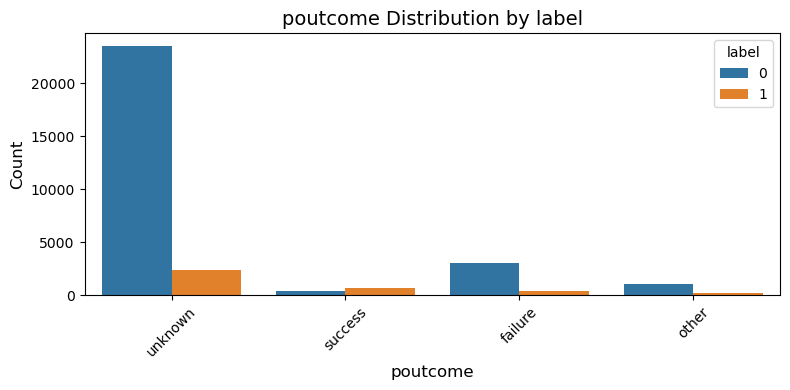

In [30]:
# 그래프 시각화
for col in cat_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=col, hue='label', data=df_trn)
    plt.xticks(rotation=45)  # x축 레이블 45도 회전
    plt.title(f'{col} Distribution by label', fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.tight_layout()  # 레이아웃 조정
    plt.show()

In [31]:
# 범주형 변수 종류에 따른 가입률 비율
for col in cat_cols:
    print(df_trn.groupby(col)['label'].mean().sort_values(ascending=False))
    print('-----------------------------------')

job
student          0.282443
retired          0.244962
unemployed       0.146129
management       0.136138
unknown          0.121212
admin.           0.120864
self-employed    0.120674
technician       0.109304
services         0.090118
entrepreneur     0.086629
housemaid        0.083236
blue-collar      0.071755
Name: label, dtype: float64
-----------------------------------
marital
single      0.144668
divorced    0.123477
married     0.102668
Name: label, dtype: float64
-----------------------------------
education
tertiary     0.148065
unknown      0.134902
secondary    0.106708
primary      0.086200
Name: label, dtype: float64
-----------------------------------
default
no     0.117791
yes    0.071685
Name: label, dtype: float64
-----------------------------------
housing
no     0.168425
yes    0.076006
Name: label, dtype: float64
-----------------------------------
loan
no     0.126348
yes    0.067396
Name: label, dtype: float64
-----------------------------------
contact
cellul

## 3. Preprocseeing

#### (1) balance 변수 -> 로그 변환 for 이상치 처리

In [34]:
df_trn['balance'].describe()

count     31647.000000
mean       1370.050084
std        3122.054996
min       -4057.000000
25%          73.000000
50%         451.000000
75%        1418.500000
max      102127.000000
Name: balance, dtype: float64

In [35]:
# 음수값 행 확인
negative_balance_count = df_trn[df_trn['balance'] < 0].shape[0]
print("음수값 행 개수:",negative_balance_count)
print("음수값 행 비율:",negative_balance_count / df_trn.shape[0])

음수값 행 개수: 2627
음수값 행 비율: 0.08300944797295162


In [36]:
# 통장 잔고이기 때문에 음수값 그대로 두고, 양수 값은 로그 변환
def transform_balance(row, column_name):
    balance_value = row[column_name]
    
    if balance_value < 0:
        return balance_value  # 음수는 그대로 두기
    else:
        return np.log(balance_value + 1)  # 양수는 로그 변환 (0의 값을 고려해 1을 더한 후 진행)

#### (2) month 변수 -> 각 달별 가입 비율을 추가하는 특성 엔지니어링

In [38]:
# 각 달별 가입 비율
(df_trn.groupby('month')['label'].mean().sort_values(ascending=False))

month
mar    0.507003
dec    0.462585
oct    0.451796
sep    0.447761
apr    0.190882
feb    0.168700
aug    0.114616
nov    0.104032
jan    0.103448
jun    0.101178
jul    0.090909
may    0.064994
Name: label, dtype: float64

In [39]:
# 각 달의 데이터 수
df_trn['month'].value_counts()

month
may    9647
jul    4807
aug    4406
jun    3736
nov    2778
apr    1996
feb    1885
jan     957
oct     529
sep     402
mar     357
dec     147
Name: count, dtype: int64

In [40]:
# 각 달별 가입 비율
month_probability = {
    'jan': 0.103448, 'feb': 0.168700, 'mar': 0.507003, 'apr': 0.190882, 
    'may': 0.064994, 'jun': 0.101178, 'jul': 0.090909, 'aug': 0.114616, 
    'sep': 0.447761, 'oct': 0.451796, 'nov': 0.104032, 'dec': 0.462585
}

In [41]:
# 가입 확률 추가 함수
def add_month_probability(df, month_probability):
    df['month_prob'] = df['month'].map(month_probability)
    return df

#### (3) poutcome 변수 -> 각 카테고리별 가입 비율을 추가하는 특성 엔지니어링

In [43]:
(df_trn.groupby('poutcome')['label'].mean().sort_values(ascending=False))

poutcome
success    0.648571
other      0.166005
failure    0.120760
unknown    0.092561
Name: label, dtype: float64

In [44]:
# 'poutcome'에 대한 가입 비율
poutcome_probability = {
    'success': 0.648571,
    'other': 0.166005,
    'failure': 0.120760,
    'unknown': 0.092561
}

In [45]:
# 가입 비율 추가 함수
def add_poutcome_probability(df, poutcome_probability):
    df['poutcome_prob'] = df['poutcome'].map(poutcome_probability)
    return df

#### (4) bool column -> ( 'yes' = 1, 'no' = 0 )

In [47]:
# 'yes' -> 1 / 'no' -> 0
def get_dummy_from_bool(row, column_name):
    return 1 if row[column_name] == 'yes' else 0

#### (5) 함수 사용해서 변수 생성 및 전처리 진행

In [49]:
def clean_data(df):

    #데이터 복사 -> 원본 데이터를 변경하지 않기 위해 사용
    cleaned_df = df.copy()

    # 1. balance 변수 처리: 로그 변환
    cleaned_df['balance_log'] = df.apply(lambda row: transform_balance(row, 'balance'), axis=1)
    cleaned_df = cleaned_df.drop(columns=['balance']) # 기존 balance 컬럼 삭제

    # 2. month 변수 처리: 각 월별 가입 확률을 특성으로 추가
    cleaned_df = add_month_probability(cleaned_df, month_probability)

    # 3. poutcome 변수 처리: 각 카테고리 별 가입 확률을 특성으로 추가
    cleaned_df = add_poutcome_probability(cleaned_df, poutcome_probability)

    # 4. bool column 변환
    bool_columns = ['default', 'housing', 'loan'] # bool 컬럼 정의
    for bool_col in bool_columns:
        cleaned_df[bool_col + '_bool'] = df.apply(lambda row: get_dummy_from_bool(row, bool_col),axis=1)
    cleaned_df = cleaned_df.drop(columns = bool_columns) # 기존 bool 칼럼 삭제

    return cleaned_df

In [50]:
# train 데이터(df_trn)에 적용
clean_df_trn = clean_data(df_trn)

In [51]:
clean_df_trn.head()

,ID,age,job,marital,education,contact,day,month,duration,campaign,pdays,previous,poutcome,label,balance_log,month_prob,poutcome_prob,default_bool,housing_bool,loan_bool
0,train00001,34,blue-collar,married,primary,unknown,23,may,100,4,-1,0,unknown,0,5.883322,0.064994,0.092561,0,1,0
1,train00002,33,blue-collar,married,secondary,unknown,20,may,172,1,-1,0,unknown,0,-53.000000,0.064994,0.092561,0,1,0
2,train00003,32,management,single,tertiary,cellular,2,feb,56,1,-1,0,unknown,0,5.337538,0.168700,0.092561,0,1,0
3,train00004,37,blue-collar,divorced,secondary,cellular,8,may,326,1,326,2,success,0,6.459904,0.064994,0.648571,0,1,0
4,train00005,33,housemaid,married,secondary,cellular,11,may,256,1,-1,0,unknown,0,6.717805,0.064994,0.092561,0,1,0


In [52]:
clean_df_trn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31647 entries, 0 to 31646
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             31647 non-null  object 
 1   age            31647 non-null  int64  
 2   job            31647 non-null  object 
 3   marital        31647 non-null  object 
 4   education      31647 non-null  object 
 5   contact        31647 non-null  object 
 6   day            31647 non-null  int64  
 7   month          31647 non-null  object 
 8   duration       31647 non-null  int64  
 9   campaign       31647 non-null  int64  
 10  pdays          31647 non-null  int64  
 11  previous       31647 non-null  int64  
 12  poutcome       31647 non-null  object 
 13  label          31647 non-null  int64  
 14  balance_log    31647 non-null  float64
 15  month_prob     31647 non-null  float64
 16  poutcome_prob  31647 non-null  float64
 17  default_bool   31647 non-null  int64  
 18  housin

In [53]:
# test 데이터(df_tst)에 적용
clean_df_tst = clean_data(df_tst)

In [54]:
clean_df_tst.head()

,ID,age,job,marital,education,contact,day,month,duration,campaign,pdays,previous,poutcome,label,balance_log,month_prob,poutcome_prob,default_bool,housing_bool,loan_bool
0,test00001,54,management,divorced,tertiary,cellular,20,nov,101,2,-1,0,unknown,NaN,8.765771,0.104032,0.092561,0,0,0
1,test00002,56,unemployed,divorced,primary,cellular,28,jan,156,2,-1,0,unknown,NaN,5.645447,0.103448,0.092561,0,0,0
2,test00003,34,management,married,secondary,cellular,21,aug,314,3,-1,0,unknown,NaN,5.874931,0.114616,0.092561,0,0,0
3,test00004,55,management,married,tertiary,cellular,12,aug,940,10,-1,0,unknown,NaN,6.343880,0.114616,0.092561,0,0,0
4,test00005,38,technician,married,secondary,cellular,21,aug,252,4,-1,0,unknown,NaN,8.814182,0.114616,0.092561,0,0,0


In [55]:
clean_df_tst.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13564 entries, 0 to 13563
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             13564 non-null  object 
 1   age            13564 non-null  int64  
 2   job            13564 non-null  object 
 3   marital        13564 non-null  object 
 4   education      13564 non-null  object 
 5   contact        13564 non-null  object 
 6   day            13564 non-null  int64  
 7   month          13564 non-null  object 
 8   duration       13564 non-null  int64  
 9   campaign       13564 non-null  int64  
 10  pdays          13564 non-null  int64  
 11  previous       13564 non-null  int64  
 12  poutcome       13564 non-null  object 
 13  label          0 non-null      float64
 14  balance_log    13564 non-null  float64
 15  month_prob     13564 non-null  float64
 16  poutcome_prob  13564 non-null  float64
 17  default_bool   13564 non-null  int64  
 18  housin

#### (6) LabelEncoder()로 범주형 변수 인코딩

In [57]:
# LabelEncoder 객체 저장용 딕셔너리
# test 데이터 예측시, 같은 label Encoder를 사용해야 하기 때문에 설정
label_encoders = {}

In [58]:
for col in clean_df_trn.columns:
    if clean_df_trn[col].dtype == 'O' and col != 'ID':  # 문자열/범주형 컬럼에 대해 (ID 컬럼 제외)
        labne = LabelEncoder()
        clean_df_trn[col] = labne.fit_transform(clean_df_trn[col])
        label_encoders[col] = labne  # 각 열에 대한 LabelEncoder 객체 저장

In [59]:
label_encoders

{'job': LabelEncoder(),
 'marital': LabelEncoder(),
 'education': LabelEncoder(),
 'contact': LabelEncoder(),
 'month': LabelEncoder(),
 'poutcome': LabelEncoder()}

In [60]:
clean_df_trn.head()

,ID,age,job,marital,education,contact,day,month,duration,campaign,pdays,previous,poutcome,label,balance_log,month_prob,poutcome_prob,default_bool,housing_bool,loan_bool
0,train00001,34,1,1,0,2,23,8,100,4,-1,0,3,0,5.883322,0.064994,0.092561,0,1,0
1,train00002,33,1,1,1,2,20,8,172,1,-1,0,3,0,-53.000000,0.064994,0.092561,0,1,0
2,train00003,32,4,2,2,0,2,3,56,1,-1,0,3,0,5.337538,0.168700,0.092561,0,1,0
3,train00004,37,1,0,1,0,8,8,326,1,326,2,2,0,6.459904,0.064994,0.648571,0,1,0
4,train00005,33,3,1,1,0,11,8,256,1,-1,0,3,0,6.717805,0.064994,0.092561,0,1,0


In [61]:
clean_df_trn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31647 entries, 0 to 31646
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             31647 non-null  object 
 1   age            31647 non-null  int64  
 2   job            31647 non-null  int32  
 3   marital        31647 non-null  int32  
 4   education      31647 non-null  int32  
 5   contact        31647 non-null  int32  
 6   day            31647 non-null  int64  
 7   month          31647 non-null  int32  
 8   duration       31647 non-null  int64  
 9   campaign       31647 non-null  int64  
 10  pdays          31647 non-null  int64  
 11  previous       31647 non-null  int64  
 12  poutcome       31647 non-null  int32  
 13  label          31647 non-null  int64  
 14  balance_log    31647 non-null  float64
 15  month_prob     31647 non-null  float64
 16  poutcome_prob  31647 non-null  float64
 17  default_bool   31647 non-null  int64  
 18  housin

In [62]:
for col in clean_df_tst.columns:
    if clean_df_tst[col].dtype == 'O' and col != 'ID' and col in label_encoders:
    # 'id' 컬럼은 제외하고, 범주형 컬럼에 대해서만 LabelEncoder 적용
        labne = label_encoders[col]
        clean_df_tst[col] = labne.transform(clean_df_tst[col])

In [63]:
clean_df_tst.head()

,ID,age,job,marital,education,contact,day,month,duration,campaign,pdays,previous,poutcome,label,balance_log,month_prob,poutcome_prob,default_bool,housing_bool,loan_bool
0,test00001,54,4,0,2,0,20,9,101,2,-1,0,3,NaN,8.765771,0.104032,0.092561,0,0,0
1,test00002,56,10,0,0,0,28,4,156,2,-1,0,3,NaN,5.645447,0.103448,0.092561,0,0,0
2,test00003,34,4,1,1,0,21,1,314,3,-1,0,3,NaN,5.874931,0.114616,0.092561,0,0,0
3,test00004,55,4,1,2,0,12,1,940,10,-1,0,3,NaN,6.343880,0.114616,0.092561,0,0,0
4,test00005,38,9,1,1,0,21,1,252,4,-1,0,3,NaN,8.814182,0.114616,0.092561,0,0,0


In [64]:
clean_df_tst.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13564 entries, 0 to 13563
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             13564 non-null  object 
 1   age            13564 non-null  int64  
 2   job            13564 non-null  int32  
 3   marital        13564 non-null  int32  
 4   education      13564 non-null  int32  
 5   contact        13564 non-null  int32  
 6   day            13564 non-null  int64  
 7   month          13564 non-null  int32  
 8   duration       13564 non-null  int64  
 9   campaign       13564 non-null  int64  
 10  pdays          13564 non-null  int64  
 11  previous       13564 non-null  int64  
 12  poutcome       13564 non-null  int32  
 13  label          0 non-null      float64
 14  balance_log    13564 non-null  float64
 15  month_prob     13564 non-null  float64
 16  poutcome_prob  13564 non-null  float64
 17  default_bool   13564 non-null  int64  
 18  housin

## 4. Train model

#### (1) 독립변수(X) 종속변수(y) 정의

In [67]:
total_cols = [x for x in clean_df_trn.columns]

id_cols = ['ID']
y_cols = ['label']
x_cols = [col for col in total_cols if col not in id_cols + y_cols]

In [68]:
X = clean_df_trn[x_cols]
y = clean_df_trn[y_cols]

#### (2) Imbalanced data 해결 ->  SMOTE 적용 (OverSampling)

In [70]:
sm = SMOTE(random_state=17)

In [71]:
X_sm, y_sm = sm.fit_resample(X, y)

In [72]:
print(y.value_counts()) # SMOTE 적용 전
print('-------------------')
print('-------------------')
print(y_sm.value_counts()) # SMOTE 적용 후

label
0        27945
1         3702
Name: count, dtype: int64
-------------------
-------------------
label
0        27945
1        27945
Name: count, dtype: int64


In [73]:
print(X.shape) # SMOTE 적용 전
print('-------------------')
print('-------------------')
print(X_sm.shape) # SMOTE 적용 후

(31647, 18)
-------------------
-------------------
(55890, 18)


#### (3) Train 데이터셋 분리

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.2, random_state=17,  stratify = y_sm)

#### (4) 모델 정의 및 최적 파라미터 탐색

In [77]:
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 10, 200) # 트리 개수 10~200 사이 탐색
    max_depth = trial.suggest_int('max_depth', 5, 200) # 트리의 최대 깊이를 5~200 사이 탐색
    min_samples_split = trial.suggest_int('min_samples_split', 2, 50) # 최소 샘플 수 2~50 사이 탐색
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss'] ) # 분할 품질 측정 기준
    #train.sugget_* 메서드를 사용해 각 하이퍼파라미터의 범위 또는 값 집합을 지정
    
    params = {
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'criterion': criterion
    }
    
    model = RandomForestClassifier(random_state=17, **params) # 지정된 하이퍼파라미터로 모델 생성
    
    score = cross_val_score(model, X_train, y_train, n_jobs=-1 , cv=5).mean() # 5-fold 교차 검증 수행하여 모델의 평균 점수 계산

    return score # score을 반환하여 Optunar가 최대화 하도록 실행

In [78]:
# 최적화 과정을 관리하는 study 객체 생성
# 랜덤 샘플링
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.RandomSampler(seed=17))

[I 2024-12-02 17:02:43,635] A new study created in memory with name: no-name-d91cf713-80e1-48bc-b914-082ebf0a2839


In [79]:
# 함수를 50번 호출하며 최적의 하이퍼파라미터 탐색
study.optimize(objective, n_trials=50)

[I 2024-12-02 17:03:01,959] Trial 0 finished with value: 0.9393227862048248 and parameters: {'n_estimators': 66, 'max_depth': 108, 'min_samples_split': 11, 'criterion': 'entropy'}. Best is trial 0 with value: 0.9393227862048248.
[I 2024-12-02 17:03:29,643] Trial 1 finished with value: 0.9447798731662516 and parameters: {'n_estimators': 131, 'max_depth': 117, 'min_samples_split': 3, 'criterion': 'entropy'}. Best is trial 1 with value: 0.9447798731662516.
[I 2024-12-02 17:03:56,178] Trial 2 finished with value: 0.942565750986397 and parameters: {'n_estimators': 175, 'max_depth': 176, 'min_samples_split': 4, 'criterion': 'gini'}. Best is trial 1 with value: 0.9447798731662516.
[I 2024-12-02 17:04:11,246] Trial 3 finished with value: 0.9376677705289893 and parameters: {'n_estimators': 102, 'max_depth': 60, 'min_samples_split': 16, 'criterion': 'log_loss'}. Best is trial 1 with value: 0.9447798731662516.
[I 2024-12-02 17:04:25,049] Trial 4 finished with value: 0.9397030193436885 and paramet

In [80]:
# 최적의 파마리터 확인
study.best_params

{'n_estimators': 131,
 'max_depth': 117,
 'min_samples_split': 3,
 'criterion': 'entropy'}

#### (5) 최적의 하이퍼파라미터를 반영해 모델 학습

In [82]:
rfc_model = RandomForestClassifier(random_state=17, **study.best_params)

In [83]:
rfc_model.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=117, min_samples_split=3,
                       n_estimators=131, random_state=17)

## 5. Model Evaluation

In [85]:
y_test_pred = rfc_model.predict(X_test)

In [86]:
y_test_score = rfc_model.predict_proba(X_test)

In [87]:
# class 1이 positive class일 때
tst_acc = accuracy_score(y_true=y_test.values, 
                         y_pred=y_test_pred)

tst_pre = precision_score(y_true=y_test.values, 
                          y_pred=y_test_pred, 
                          pos_label=1)

tst_rec = recall_score(y_true=y_test.values, 
                       y_pred=y_test_pred, 
                       pos_label=1)

tst_f1 = f1_score(y_true=y_test.values, 
                  y_pred=y_test_pred, 
                  pos_label=1)

tst_auroc = roc_auc_score(y_true=y_test.values, 
                          y_score=y_test_score[:,1])

In [88]:
print(f'In test set, accuracy={tst_acc:.4f}, precision={tst_pre:.4f}, recall={tst_rec:.4f}, f1={tst_f1:.4f}')
print(f'In test set, AUROC={tst_auroc:.4f}')

In test set, accuracy=0.9455, precision=0.9343, recall=0.9585, f1=0.9462
In test set, AUROC=0.9907


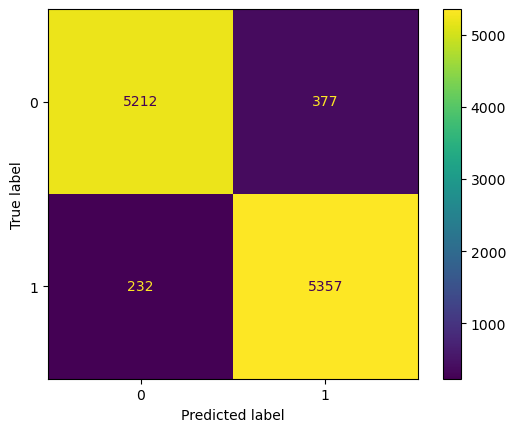

In [89]:
ConfusionMatrixDisplay.from_predictions(y_true=y_test, 
                                        y_pred=y_test_pred)

## 5. Predict

In [91]:
clean_df_tst.head()

,ID,age,job,marital,education,contact,day,month,duration,campaign,pdays,previous,poutcome,label,balance_log,month_prob,poutcome_prob,default_bool,housing_bool,loan_bool
0,test00001,54,4,0,2,0,20,9,101,2,-1,0,3,NaN,8.765771,0.104032,0.092561,0,0,0
1,test00002,56,10,0,0,0,28,4,156,2,-1,0,3,NaN,5.645447,0.103448,0.092561,0,0,0
2,test00003,34,4,1,1,0,21,1,314,3,-1,0,3,NaN,5.874931,0.114616,0.092561,0,0,0
3,test00004,55,4,1,2,0,12,1,940,10,-1,0,3,NaN,6.343880,0.114616,0.092561,0,0,0
4,test00005,38,9,1,1,0,21,1,252,4,-1,0,3,NaN,8.814182,0.114616,0.092561,0,0,0


In [92]:
X = clean_df_tst[x_cols]

In [93]:
y_pred = rfc_model.predict(X)

In [94]:
clean_df_tst['label'] = y_pred

In [95]:
clean_df_tst['label'].value_counts()

label
0    11782
1     1782
Name: count, dtype: int64

## 6. 예측 결과를 submission에 넣고 저장하기

In [97]:
submission = clean_df_tst[['ID','label']]

In [98]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13564 entries, 0 to 13563
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      13564 non-null  object
 1   label   13564 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 212.1+ KB


In [99]:
submission.to_csv('submission/submission_RF(SMOTE).csv', index = False)